# Лабораторная работа №3. Классификация. Нейронные сети

## 1. Введение

**Цель работы:** исследование методов анализа ассоциативных правил.

**Постановка задачи:**

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## 2. Выбор и подготовка датасета

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import itertools
import os
import kagglehub
layers = tf.keras.layers
models = tf.keras.models
optimizers = tf.keras.optimizers
TensorBoard = tf.keras.callbacks.TensorBoard

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

path = kagglehub.dataset_download("nimapourmoradi/raisin-binary-classification")
file_path = os.path.join(path, "Raisin_Dataset.csv")
df = pd.read_csv(file_path)

df['Class'] = df['Class'].map({
    'Kecimen': 0,
    'Besni': 1
})

X = df.drop('Class', axis=1)
y = df['Class']

bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype(int)

binary_cols = []
for col in X.columns:
    if set(X[col].dropna().unique()) <= {0, 1}:
        binary_cols.append(col)

numeric_cols = [col for col in X.columns if col not in binary_cols]

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print(y.value_counts())
X.head()

Class
0    450
1    450
Name: count, dtype: int64


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,-0.007186,0.097577,-0.023958,0.423142,-0.015709,1.106743,0.066274
1,-0.324217,-0.209012,-0.229292,0.224476,-0.304248,-0.287777,-0.161252
2,0.078292,0.097758,0.236988,0.186239,0.062113,-1.158250,0.155945
3,-1.074286,-1.245051,-0.915273,-1.069623,-1.076165,0.001711,-1.175915
4,-0.215393,-0.678958,0.727354,-2.409827,-0.238623,1.745259,-0.338639


## 3. Разбиение выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Размер обучающей выборки:", X_train.shape)
print("Баланс классов в обучении:")
print(y_train.value_counts())

results = []

Размер обучающей выборки: (720, 7)
Баланс классов в обучении:
Class
0    360
1    360
Name: count, dtype: int64


## 4. Методы классификации и Настройка гиперпараметров

### a. Наивный Байесовский классификатор

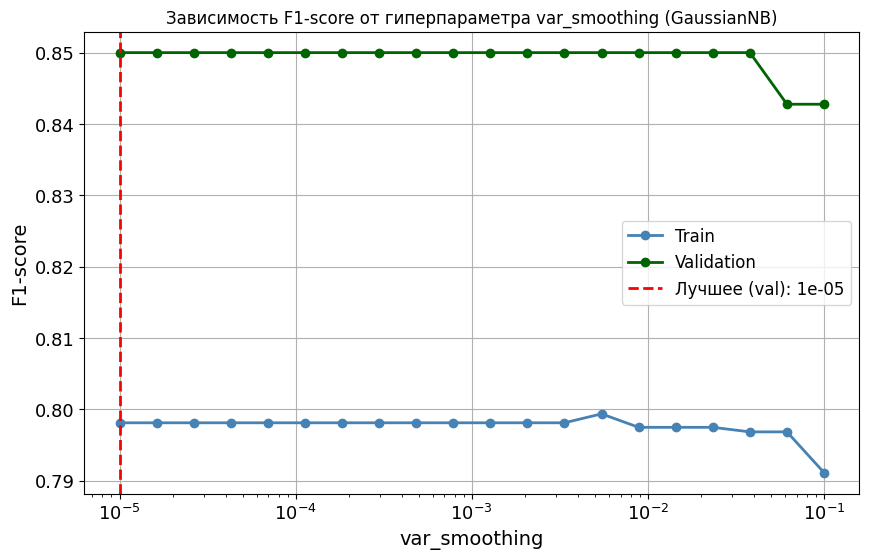


Лучшая модель GaussianNB при var_smoothing = 1e-05:
Accuracy: 0.8667
Precision: 0.9714
Recall: 0.7556
F1: 0.8500
AUC-ROC: 0.9451


In [14]:
var_smoothing_values = np.logspace(-5, -1, 20)

f1_train_scores = []
f1_val_scores = []

for vs in var_smoothing_values:
    nb = GaussianNB(var_smoothing=vs)
    nb.fit(X_train, y_train)
    
    y_pred_train = nb.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train)
    f1_train_scores.append(f1_train)
    
    y_pred_val = nb.predict(X_test)
    f1_val = f1_score(y_test, y_pred_val)
    f1_val_scores.append(f1_val)

best_idx = np.argmax(f1_val_scores)
best_vs = var_smoothing_values[best_idx]
best_f1_val = f1_val_scores[best_idx]

plt.figure(figsize=(10, 6))
plt.semilogx(var_smoothing_values, f1_train_scores, 
             marker='o', linestyle='-', color='steelblue', label='Train', linewidth=2)
plt.semilogx(var_smoothing_values, f1_val_scores, 
             marker='o', linestyle='-', color='darkgreen', label='Validation', linewidth=2)
plt.axvline(best_vs, color='red', linestyle='--', linewidth=2, 
            label=f'Лучшее (val): {best_vs:.0e}')
plt.xlabel('var_smoothing', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от гиперпараметра var_smoothing (GaussianNB)')
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

nb_best = GaussianNB(var_smoothing=best_vs)
nb_best.fit(X_train, y_train)

y_pred_best = nb_best.predict(X_test)
y_proba_best = nb_best.predict_proba(X_test)[:, 1]

metrics_nb = {
    'Model': 'GaussianNB',
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1': f1_score(y_test, y_pred_best),
    'AUC-ROC': roc_auc_score(y_test, y_proba_best)
}
results.append(metrics_nb)

print(f"\nЛучшая модель GaussianNB при var_smoothing = {best_vs:.0e}:")
for metric, value in metrics_nb.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

**Вывод:** На графике наблюдается интересная особенность, где валидационная кривая (зеленая) находится выше обучающей (синей). Такое поведение характерно для небольших датасетов. При увеличении var_smoothing выше 10(^−2) (правая часть графика) наблюдается резкое падение точности. Это объясняется тем, что слишком сильное сглаживание «размывает» распределения признаков, и модели становится сложнее различать сорта изюма.

### b. Деревья решений

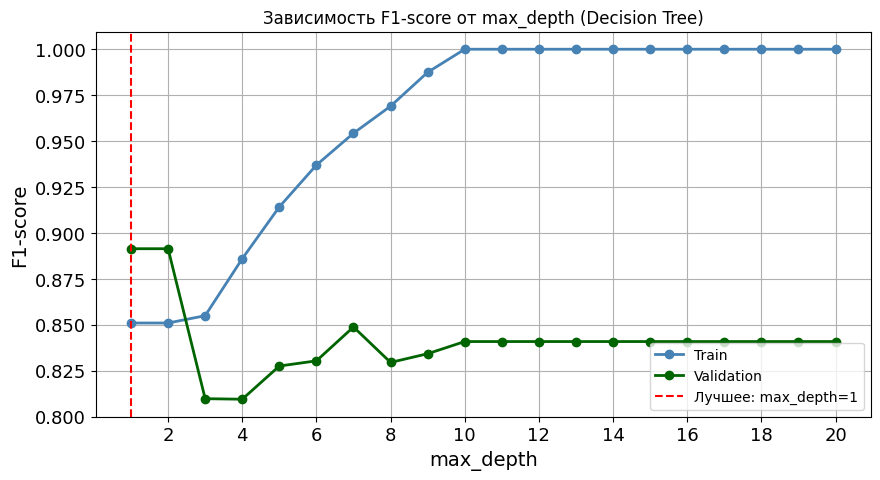

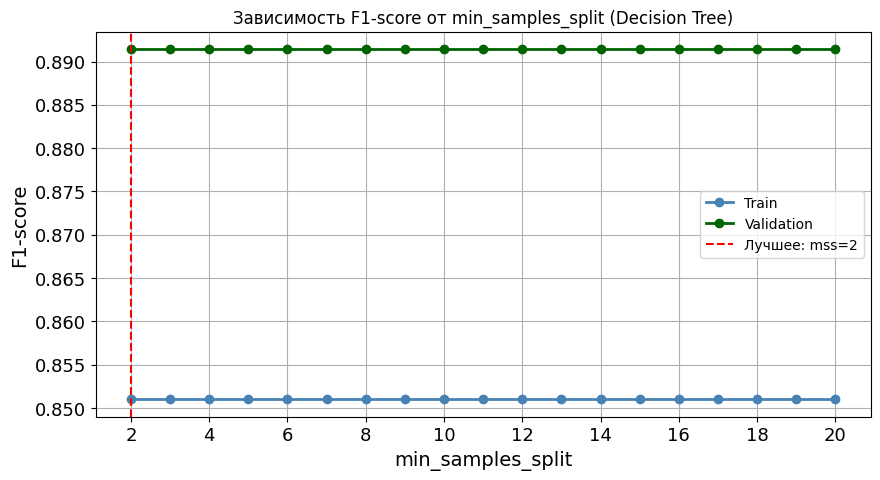


Лучшая модель Decision Tree при max_depth = 1, min_samples_split = 2
Accuracy: 0.8944
Precision: 0.9176
Recall: 0.8667
F1: 0.8914
AUC-ROC: 0.8944


In [15]:
max_depths = range(1, 21)

f1_train_depth = []
f1_val_depth = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    y_pred_train = dt.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train)
    f1_train_depth.append(f1_train)
    
    y_pred_val = dt.predict(X_test)
    f1_val = f1_score(y_test, y_pred_val)
    f1_val_depth.append(f1_val)

best_depth = max_depths[np.argmax(f1_val_depth)]
best_f1_depth = f1_val_depth[np.argmax(f1_val_depth)]

plt.figure(figsize=(10, 5))
plt.plot(max_depths, f1_train_depth, marker='o', color='steelblue', label='Train', linewidth=2)
plt.plot(max_depths, f1_val_depth, marker='o', color='darkgreen', label='Validation', linewidth=2)
plt.axvline(best_depth, color='red', linestyle='--', label=f'Лучшее: max_depth={best_depth}')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от max_depth (Decision Tree)')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

min_samples_splits = range(2, 21)

f1_train_split = []
f1_val_split = []

for mss in min_samples_splits:
    dt = DecisionTreeClassifier(
        max_depth=best_depth,
        min_samples_split=mss,
        random_state=42
    )
    dt.fit(X_train, y_train)

    y_pred_train = dt.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train)
    f1_train_split.append(f1_train)

    y_pred_val = dt.predict(X_test)
    f1_val = f1_score(y_test, y_pred_val)
    f1_val_split.append(f1_val)

best_mss = min_samples_splits[np.argmax(f1_val_split)]
best_f1_mss = f1_val_split[np.argmax(f1_val_split)]


plt.figure(figsize=(10, 5))
plt.plot(min_samples_splits, f1_train_split, marker='o', color='steelblue', label='Train', linewidth=2)
plt.plot(min_samples_splits, f1_val_split, marker='o', color='darkgreen', label='Validation', linewidth=2)
plt.axvline(best_mss, color='red', linestyle='--', label=f'Лучшее: mss={best_mss}')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlabel('min_samples_split', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от min_samples_split (Decision Tree)')
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()

dt_best = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_mss,
    random_state=42
)
dt_best.fit(X_train, y_train)

y_pred_dt = dt_best.predict(X_test)
y_proba_dt = dt_best.predict_proba(X_test)[:, 1]

metrics_dt = {
    'Model': 'DecisionTree',
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1': f1_score(y_test, y_pred_dt),
    'AUC-ROC': roc_auc_score(y_test, y_proba_dt)
}
results.append(metrics_dt)

print(f"\nЛучшая модель Decision Tree при max_depth = {best_depth}, min_samples_split = {best_mss}")
for metric, value in metrics_dt.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

**Вывод:** График показывает, что наилучшее качество на валидации (F1 ≈ 0.89) достигается при глубине дерева всего 1 или 2.
Это означает, что для различения двух сортов изюма достаточно одного-двух ключевых правил. Такое дерево называется «решающим пнем». Оно максимально простое и интерпретируемое.

На первом графике четко видно классическое переобучение. Синяя линия (Train) при увеличении глубины стремительно растет и достигает 1.00 (100%) при глубине 10. Модель просто «зазубрила» обучающую выборку. Зеленая линия (Validation) качеством на тесте резко падает (с 0.89 до 0.81) уже после 2-го уровня глубины и перестает расти. Это подтверждает, что усложнение модели только вредит.

Здесь снова наблюдается ситуация, когда валидация (зеленая) выше обучения (синяя) на начальных этапах. Это подтверждает гипотезу о том, что в тестовую выборку попали более «очевидные» примеры, которые легко разделяются даже одним простым правилом. Простое Дерево решений с глубиной 1 (или 2) работает лучше всего, достигая F1-score около 0.89, что является отличным результатом. Дальнейшее усложнение модели ведет к переобучению.

### c. Линейный дискриминантный анализ

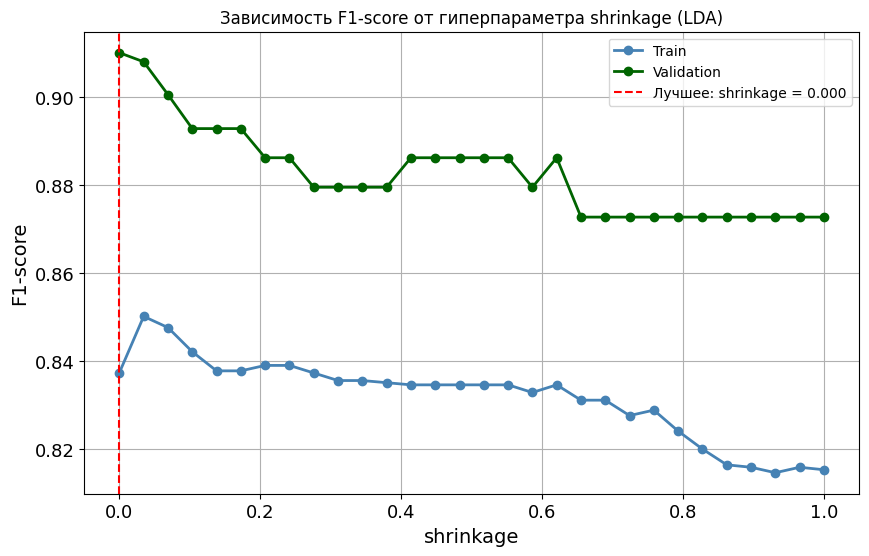


Лучшая модель LDA при shrinkage = 0.000
Accuracy: 0.9111
Precision: 0.9205
Recall: 0.9000
F1: 0.9101
AUC-ROC: 0.9600


In [16]:
shrinkage_values = np.linspace(0.0, 1.0, 30)

f1_train_lda = []
f1_val_lda = []

for shrink in shrinkage_values:
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrink)
    lda.fit(X_train, y_train)
    
    y_pred_train = lda.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train)
    f1_train_lda.append(f1_train)
    
    y_pred_val = lda.predict(X_test)
    f1_val = f1_score(y_test, y_pred_val)
    f1_val_lda.append(f1_val)

best_idx_lda = np.argmax(f1_val_lda)
best_shrinkage = shrinkage_values[best_idx_lda]
best_f1_lda = f1_val_lda[best_idx_lda]

plt.figure(figsize=(10, 6))
plt.plot(shrinkage_values, f1_train_lda, marker='o', linestyle='-', color='steelblue', 
         label='Train', linewidth=2)
plt.plot(shrinkage_values, f1_val_lda, marker='o', linestyle='-', color='darkgreen', 
         label='Validation', linewidth=2)
plt.axvline(best_shrinkage, color='red', linestyle='--', label=f'Лучшее: shrinkage = {best_shrinkage:.3f}')
plt.xlabel('shrinkage', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от гиперпараметра shrinkage (LDA)')
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()

lda_best = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shrinkage)
lda_best.fit(X_train, y_train)

y_pred_lda = lda_best.predict(X_test)
y_proba_lda = lda_best.predict_proba(X_test)[:, 1]

metrics_lda = {
    'Model': 'LDA',
    'Accuracy': accuracy_score(y_test, y_pred_lda),
    'Precision': precision_score(y_test, y_pred_lda),
    'Recall': recall_score(y_test, y_pred_lda),
    'F1': f1_score(y_test, y_pred_lda),
    'AUC-ROC': roc_auc_score(y_test, y_proba_lda)
}

results.append(metrics_lda)

print(f"\nЛучшая модель LDA при shrinkage = {best_shrinkage:.3f}")
for metric, value in metrics_lda.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

**Вывод:** Наилучший результат (F1-score ≈ 0.91 на валидации) достигается при отсутствии регуляризации (shrinkage = 0). Это означает, что стандартный LDA работает лучше всего и что классы изюма (Kecimen и Besni) линейно разделимы, и LDA идеально подходит для этой задачи. График демонстрирует четкий нисходящий тренд. Чем сильнее мы увеличиваем параметр shrinkage (двигаемся вправо по оси X), тем ниже падает точность модели (как на обучении, так и на тесте).

### d. Метод опорных векторов

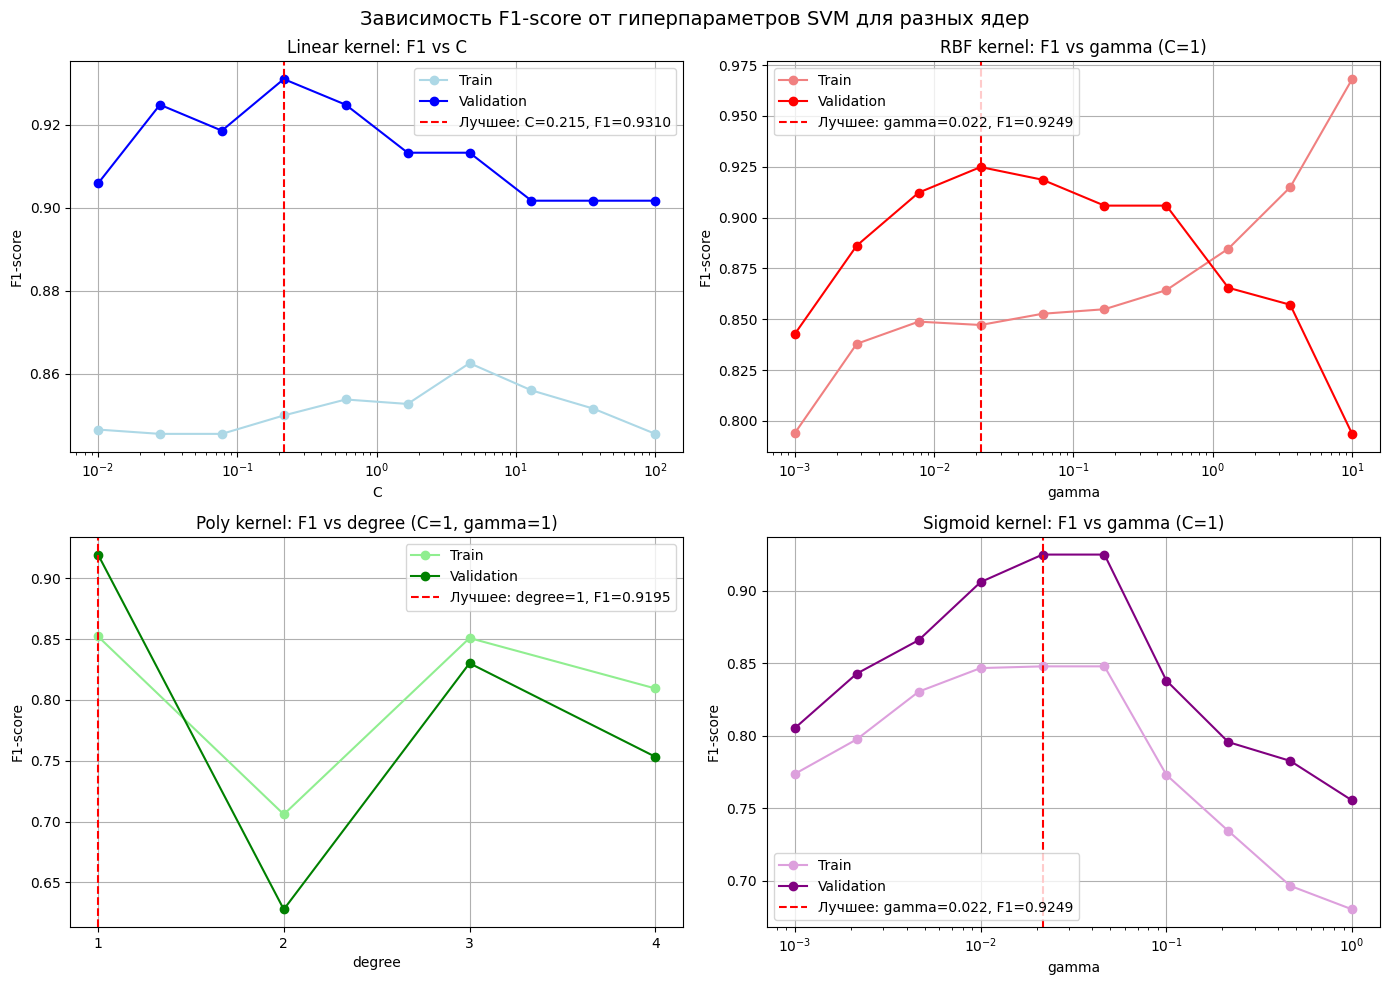


Лучшая модель  SVM с ядром 'linear':
Accuracy: 0.9278
Precision: 0.9529
Recall: 0.9000
F1: 0.9257
AUC-ROC: 0.9590


In [17]:
X_train_tune, _, y_train_tune, _ = train_test_split(
    X_train, y_train,
    random_state=42,
    stratify=y_train
)

C_values = np.logspace(-2, 2, 10)
f1_train_linear, f1_val_linear = [], []

for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train_tune, y_train_tune)

    f1_train = f1_score(y_train_tune, svm.predict(X_train_tune))
    f1_train_linear.append(f1_train)

    f1_val = f1_score(y_test, svm.predict(X_test))
    f1_val_linear.append(f1_val)

best_C_linear = C_values[np.argmax(f1_val_linear)]
best_f1_linear_val = max(f1_val_linear)

gamma_rbf = np.logspace(-3, 1, 10)
f1_train_rbf, f1_val_rbf = [], []

for g in gamma_rbf:
    svm = SVC(kernel='rbf', C=1.0, gamma=g, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1_train_rbf.append(f1_score(y_train_tune, svm.predict(X_train_tune)))
    f1_val_rbf.append(f1_score(y_test, svm.predict(X_test)))

best_gamma_rbf = gamma_rbf[np.argmax(f1_val_rbf)]
best_f1_rbf_val = max(f1_val_rbf)

degrees = [1, 2, 3, 4]
f1_train_poly, f1_val_poly = [], []

for d in degrees:
    svm = SVC(kernel='poly', C=1.0, gamma=1.0, degree=d, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1_train_poly.append(f1_score(y_train_tune, svm.predict(X_train_tune)))
    f1_val_poly.append(f1_score(y_test, svm.predict(X_test)))

best_degree_poly = degrees[np.argmax(f1_val_poly)]
best_f1_poly_val = max(f1_val_poly)

gamma_sigmoid = np.logspace(-3, 0, 10)
f1_train_sigmoid, f1_val_sigmoid = [], []

for g in gamma_sigmoid:
    svm = SVC(kernel='sigmoid', C=1.0, gamma=g, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1_train_sigmoid.append(f1_score(y_train_tune, svm.predict(X_train_tune)))
    f1_val_sigmoid.append(f1_score(y_test, svm.predict(X_test)))

best_gamma_sigmoid = gamma_sigmoid[np.argmax(f1_val_sigmoid)]
best_f1_sigmoid_val = max(f1_val_sigmoid)

results_SVM = {
    'linear': best_f1_linear_val,
    'rbf': best_f1_rbf_val,
    'poly': best_f1_poly_val,
    'sigmoid': best_f1_sigmoid_val
}
best_kernel = max(results_SVM, key=results_SVM.get)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Зависимость F1-score от гиперпараметров SVM для разных ядер', fontsize=14)

# Linear
axes[0,0].semilogx(C_values, f1_train_linear, 'o', linestyle='-', color='lightblue', label='Train')
axes[0,0].semilogx(C_values, f1_val_linear, 'o', linestyle='-', color='blue', label='Validation')
axes[0,0].axvline(best_C_linear, color='red', linestyle='--', label = f'Лучшее: C={best_C_linear:.3f}, F1={best_f1_linear_val:.4f}')
axes[0,0].set_title('Linear kernel: F1 vs C')
axes[0,0].set_xlabel('C')
axes[0,0].set_ylabel('F1-score')
axes[0,0].grid(True)
axes[0,0].legend() 

# RBF
axes[0,1].semilogx(gamma_rbf, f1_train_rbf, 'o', linestyle='-', color='lightcoral', label='Train')
axes[0,1].semilogx(gamma_rbf, f1_val_rbf, 'o', linestyle='-', color='red', label='Validation')
axes[0,1].axvline(best_gamma_rbf, color='red', linestyle='--', label = f'Лучшее: gamma={best_gamma_rbf:.3f}, F1={best_f1_rbf_val:.4f}')
axes[0,1].set_title('RBF kernel: F1 vs gamma (C=1)')
axes[0,1].set_xlabel('gamma')
axes[0,1].set_ylabel('F1-score')
axes[0,1].grid(True)
axes[0,1].legend()

# Poly
axes[1,0].plot(degrees, f1_train_poly, 'o', linestyle='-', color='lightgreen', label='Train')
axes[1,0].plot(degrees, f1_val_poly, 'o', linestyle='-', color='green', label='Validation')
axes[1,0].set_title('Poly kernel: F1 vs degree (C=1, gamma=1)')
axes[1,0].axvline(best_degree_poly, color='red', linestyle='--', label = f'Лучшее: degree={best_degree_poly}, F1={best_f1_poly_val:.4f}')
axes[1,0].set_xlabel('degree')
axes[1,0].set_ylabel('F1-score')
axes[1,0].set_xticks(degrees)
axes[1,0].grid(True)
axes[1,0].legend()

# Sigmoid
axes[1,1].semilogx(gamma_sigmoid, f1_train_sigmoid, 'o', linestyle='-', color='plum', label='Train')
axes[1,1].semilogx(gamma_sigmoid, f1_val_sigmoid, 'o', linestyle='-', color='purple', label='Validation')
axes[1,1].axvline(best_gamma_sigmoid, color='red', linestyle='--', label = f'Лучшее: gamma={best_gamma_sigmoid:.3f}, F1={best_f1_sigmoid_val:.4f}')
axes[1,1].set_title('Sigmoid kernel: F1 vs gamma (C=1)')
axes[1,1].set_xlabel('gamma')
axes[1,1].set_ylabel('F1-score')
axes[1,1].grid(True)
axes[1,1].legend()

plt.tight_layout()
plt.show()

if best_kernel == 'linear':
    best_svm = SVC(kernel='linear', C=best_C_linear, random_state=42, probability=True)
elif best_kernel == 'rbf':
    best_svm = SVC(kernel='rbf', C=1.0, gamma=best_gamma_rbf, random_state=42, probability=True)
elif best_kernel == 'poly':
    best_svm = SVC(kernel='poly', C=1.0, gamma=1.0, degree=best_degree_poly, random_state=42, probability=True)
else:
    best_svm = SVC(kernel='sigmoid', C=1.0, gamma=best_gamma_sigmoid, random_state=42, probability=True)


best_svm.fit(X_train, y_train)

y_pred_svm_final = best_svm.predict(X_test)
y_proba_svm_final = best_svm.predict_proba(X_test)[:, 1]


metrics_svm_full = {
    'Model': f'SVM ({best_kernel})',
    'Accuracy': accuracy_score(y_test, y_pred_svm_final),
    'Precision': precision_score(y_test, y_pred_svm_final),
    'Recall': recall_score(y_test, y_pred_svm_final),
    'F1': f1_score(y_test, y_pred_svm_final),
    'AUC-ROC': roc_auc_score(y_test, y_proba_svm_final)
}
results.append(metrics_svm_full)

print(f"\nЛучшая модель  SVM с ядром '{best_kernel}':")
for metric, value in metrics_svm_full.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

**Вывод:** Самый высокий показатель F1-score (0.9310) достигнут именно на линейном ядре при параметре регуляризации C≈0.2. Тот факт, что самое простое (линейное) ядро работает лучше сложных (полиномиальных или RBF), доказывает, что сорта изюма Kecimen и Besni отлично разделяются прямой линией в пространстве признаков. Усложнение модели не требуется.

График RBF — это пример переобучения. Точность на обучении (розовая линия) взлетает почти до 1.0, в то время как точность на валидации (красная линия) стремительно падает. Это значит, что при высокой gamma модель начинает просто «запоминать» обучающие примеры, теряя способность узнавать новые данные. Лучшее значение gamma находится в районе 0.02, где модель еще не переобучилась.

График Poly Kernel подтверждает лидерство линейных методов. Лучший результат достигается при degree=1 (степень 1), что фактически превращает полиномиальное ядро в линейное. При увеличении степени до 2 качество резко падает. Это говорит о том, что попытка описать границу классов кривой линией (параболой) только вносит шум и ухудшает результат.

На всех графиках (особенно Linear и Sigmoid) сохраняется тенденция, замеченная в прошлых опытах, где валидационная кривая лежит выше обучающей. Это подтверждает, что при случайном разбиении данных в тестовую выборку попали более «чистые» примеры, чем в обучающую.

### e. Метод ближайших соседей

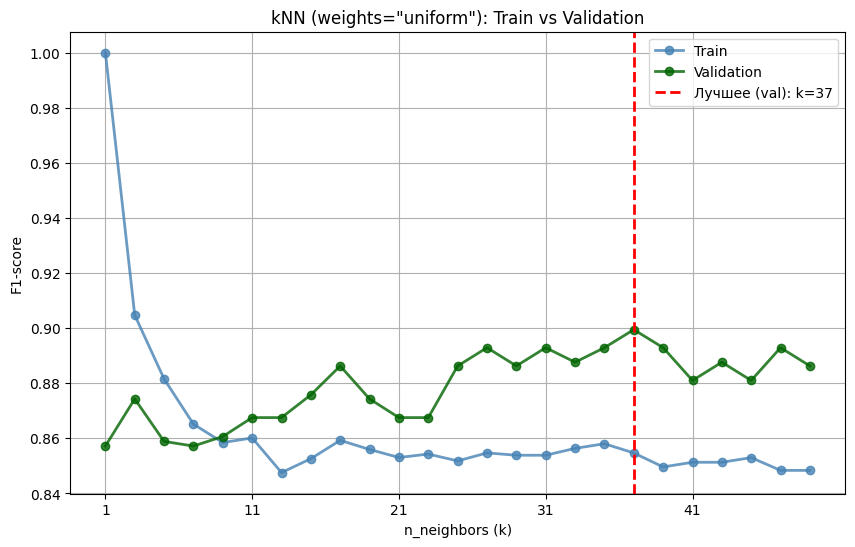

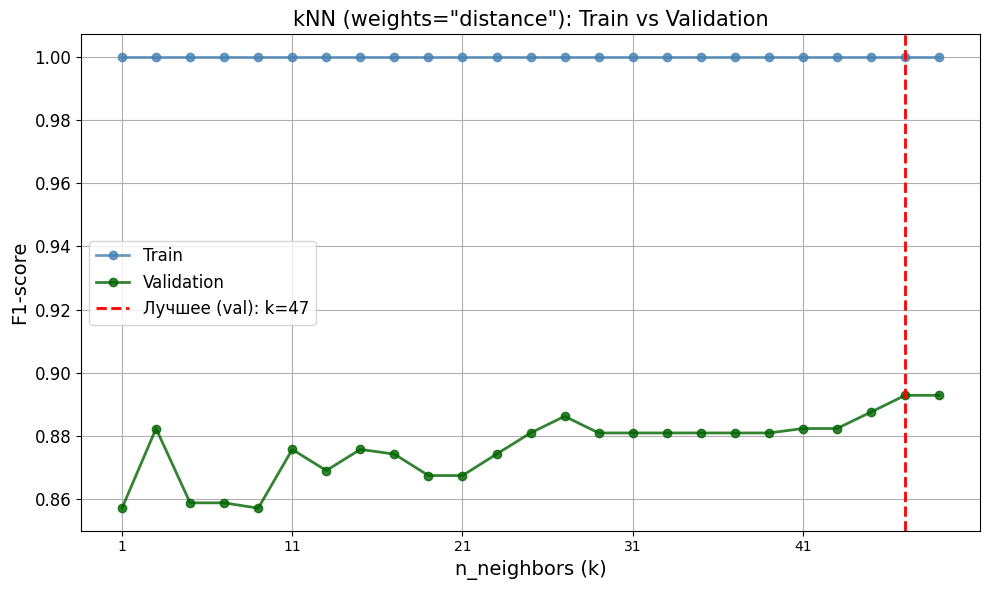


Лучшая модель kNN при weight = uniform, k = 37:
Accuracy: 0.9056
Precision: 0.9620
Recall: 0.8444
F1: 0.8994
AUC-ROC: 0.9499


In [18]:
k_values = np.arange(1, 51, 2)

f1_train_uniform, f1_val_uniform = [], []
f1_train_distance, f1_val_distance = [], []

for k in k_values:
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean', n_jobs=-1)
    knn_u.fit(X_train, y_train)
    
    y_pred_train_u = knn_u.predict(X_train)
    f1_train_uniform.append(f1_score(y_train, y_pred_train_u))
    
    y_pred_val_u = knn_u.predict(X_test)
    f1_val_uniform.append(f1_score(y_test, y_pred_val_u))
    
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)
    knn_d.fit(X_train, y_train)
    
    y_pred_train_d = knn_d.predict(X_train)
    f1_train_distance.append(f1_score(y_train, y_pred_train_d))

    y_pred_val_d = knn_d.predict(X_test)
    f1_val_distance.append(f1_score(y_test, y_pred_val_d))

best_k_uniform = k_values[np.argmax(f1_val_uniform)]
best_f1_uniform_val = max(f1_val_uniform)

best_k_distance = k_values[np.argmax(f1_val_distance)]
best_f1_distance_val = max(f1_val_distance)

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_train_uniform, 'o-', color='steelblue', label='Train', linewidth=2, alpha=0.8)
plt.plot(k_values, f1_val_uniform, 'o-', color='darkgreen', label='Validation', linewidth=2, alpha=0.8)
plt.axvline(best_k_uniform, color='red', linestyle='--', 
            label=f'Лучшее (val): k={best_k_uniform}', linewidth=2)
plt.xlabel('n_neighbors (k)')
plt.ylabel('F1-score')
plt.title('kNN (weights="uniform"): Train vs Validation')
plt.legend()
plt.grid(True)
plt.xticks(k_values[::5])
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_train_distance, 'o-', color='steelblue', label='Train', linewidth=2, alpha=0.8)
plt.plot(k_values, f1_val_distance, 'o-', color='darkgreen', label='Validation', linewidth=2, alpha=0.8)
plt.axvline(best_k_distance, color='red', linestyle='--', 
            label=f'Лучшее (val): k={best_k_distance}', linewidth=2)
plt.xlabel('n_neighbors (k)', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('kNN (weights="distance"): Train vs Validation', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(k_values[::5])
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

if best_f1_uniform_val >= best_f1_distance_val:
    best_weights = 'uniform'
    best_k = best_k_uniform
    best_f1_knn = best_f1_uniform_val
else:
    best_weights = 'distance'
    best_k = best_k_distance
    best_f1_knn = best_f1_distance_val

knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    metric='euclidean',
    n_jobs=-1
)
knn_best.fit(X_train, y_train)

y_pred_knn = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:, 1]

metrics_knn = {
    'Model': f'kNN (k={best_k}, weights={best_weights})',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1': f1_score(y_test, y_pred_knn),
    'AUC-ROC': roc_auc_score(y_test, y_proba_knn)
}

results.append(metrics_knn)

print(f"\nЛучшая модель kNN при weight = {best_weights}, k = {best_k}:")
for metric, value in metrics_knn.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

**Вывод:** Лучшие результаты достигнуты при достаточно больших значениях k (k=37 для uniform и k=47 для distance). Это говорит о том, что границы между классами изюма не являются резкими или сложными. Модели требуется собрать "мнение" большого количества соседей (почти 40-50 штук), чтобы принять верное решение и сгладить возможный шум в данных. Это согласуется с тем, что ранее линейные модели (LDA, Linear SVM) показали себя лучше всех — большое k "выпрямляет" границу решений.

Uniform (Равные веса): Показал лучший результат (F1 ≈ 0.90 при k=37). График валидации (зеленый) лежит выше графика обучения (синего), что снова подтверждает особенность разбиения данного датасета (тестовая выборка "легче" обучающей).

Distance (Взвешивание по расстоянию): Показал чуть более низкий или схожий результат.

Усложнение модели добавлением весов не дает прироста качества. Простое голосование большинства работает лучше.

На втором графике синяя линия (Train) представляет собой прямую на уровне 1.0. При взвешивании по расстоянию ближайшим соседом для любой точки обучающей выборки является она сама (расстояние = 0, вес = бесконечность). Поэтому модель всегда идеально угадывает обучающие примеры ("запоминает" их), но это не гарантирует такое же качество на новых данных.

## 5. Нейронная сеть на TensorFlow

In [22]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

input_dim = X_train.shape[1]

def create_model(hidden_layers, dropout_rate, learning_rate):
    model = models.Sequential([layers.Input(shape=(input_dim,))])
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu'))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def evaluate_f1(hidden_layers, dropout_rate, learning_rate):
    model = create_model(hidden_layers, dropout_rate, learning_rate)
    model.fit(X_train_tune, y_train_tune, epochs=15, batch_size=64, verbose=0)
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    return f1_score(y_test, y_pred)

layer_options = [[64], [128, 64], [64, 32]]
dropout_options = [0.2, 0.5]
lr_options = [0.001, 0.01]

combinations = list(itertools.product(layer_options, dropout_options, lr_options))

results_nn = []
for arch, drop, lr in combinations:
    f1 = evaluate_f1(arch, drop, lr)
    results_nn.append({
        'arch': arch,
        'dropout': drop,
        'lr': lr,
        'F1': f1
    })

df = pd.DataFrame(results_nn)
df = df.sort_values('F1', ascending=False).reset_index(drop=True)

best_config = df.iloc[0]
worst_config = df.iloc[-1]

print("Лучшая модель:")
print(f"  Архитектура: {best_config['arch']}, Dropout: {best_config['dropout']}, LR: {best_config['lr']}, F1: {best_config['F1']:.4f}")
print("\nХудшая модель:")
print(f"  Архитектура: {worst_config['arch']}, Dropout: {worst_config['dropout']}, LR: {worst_config['lr']}, F1: {worst_config['F1']:.4f}")

def train_and_log(config, name_suffix):
    model = create_model(
        hidden_layers=config['arch'],
        dropout_rate=config['dropout'],
        learning_rate=config['lr']
    )
    
    log_dir = f"logs/nn_comparison/{name_suffix}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    callbacks = [
        tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            write_graph=True
        ),
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=128,
        callbacks=callbacks,
        verbose=0
    )
    
    return model, log_dir

best_model, best_log = train_and_log(best_config, "best")
worst_model, worst_log = train_and_log(worst_config, "worst")

y_pred_best = (best_model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
y_proba_best = best_model.predict(X_test, verbose=0).flatten()

metrics_nn_best = {
    'Model': 'Neural Network (best)',
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1': f1_score(y_test, y_pred_best),
    'AUC-ROC': roc_auc_score(y_test, y_proba_best)
}

results.append(metrics_nn_best)

print("\nМетрики лучшей нейронной сети:")
for metric, value in metrics_nn_best.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

Лучшая модель:
  Архитектура: [64, 32], Dropout: 0.5, LR: 0.001, F1: 0.9257

Худшая модель:
  Архитектура: [64, 32], Dropout: 0.2, LR: 0.01, F1: 0.8743

Метрики лучшей нейронной сети:
Accuracy: 0.9222
Precision: 0.9524
Recall: 0.8889
F1: 0.9195
AUC-ROC: 0.9552


**Вывод:** Наилучший результат (F1 ≈ 0.92) показала архитектура [64, 32] с высоким уровнем регуляризации (Dropout 0.5) и низким шагом обучения (LR 0.001). Использование двух скрытых слоев позволило модели выучить необходимые нелинейные зависимости, которые сложнее линейных границ. Тот факт, что победила модель с Dropout = 0.5 (отключение 50% нейронов при обучении), подтверждает гипотезу о малом объеме данных. Датасет Raisin (900 строк) слишком мал для полноценной нейросети. Без сильного Dropout сеть начинает просто «запоминать» примеры. Высокий Dropout заставил сеть искать наиболее устойчивые и общие признаки, что повысило точность на тесте. AUC-ROC = 0.9552 великолепный показатель, говорящий о том, что модель очень уверенно ранжирует классы. Вероятность ошибки крайне мала. Precision (0.95) > Recall (0.89) нейросеть работает «осторожно». Она почти не допускает ложных срабатываний, но пропускает около 11% реальных объектов целевого класса.

In [25]:
import subprocess
import sys

subprocess.Popen([
    sys.executable, "-m", "tensorboard.main",
    "--logdir", "logs/nn_comparison",
    "--host", "127.0.0.1",
    "--port", "6006"
])

<Popen: returncode: None args: ['c:\\Users\\Anastasia\\AppData\\Local\\Progr...>

![Текст, если картинка не грузится](best1.png)

![Текст, если картинка не грузится](best2.png)

Графики выглядят как красивые, симметричные «колокола» (нормальное распределение). Они стабильны. Центр горки (пик) не гуляет сильно влево или вправо по мере спуска вниз (с течением времени). Он стоит примерно на месте, немного меняет форму. Обучение шло плавно. Благодаря маленькому Learning Rate (0.001) нейросеть аккуратно подбирала параметры, не делая резких скачков.

![Текст, если картинка не грузится](worst1.png)

![Текст, если картинка не грузится](worst2.png)

Оранжевый график очень «рваный». В начале (сверху) горка была в одном месте, а к концу (снизу) она уехала в сторону и размазалась. Розовый график тоже смещен относительно центра и имеет странную форму. Обучение было нестабильным. Из-за высокого Learning Rate (0.01) параметры нейросети «скакали» (осциллировали). Сеть пыталась найти минимум ошибки, но пролетала мимо, из-за чего значения смещений (bias) уносило в сторону. Произошёл «взрыв градиентов» или просто нестабильная сходимость.

Лучшая модель демонстрирует стабильные гистограммы с распределением, близким к нормальному (Гауссову). Параметры меняются плавно, что говорит о правильно подобранной скорости обучения (LR=0.001).

Худшая модель демонстрирует «дрейф» параметров и неправильную форму распределений. Значения смещений (biases) сильно сдвигаются в процессе обучения, что свидетельствует о слишком большом шаге обучения (LR=0.01), который мешает модели зафиксироваться в оптимальной точке.

![Текст, если картинка не грузится](accuracy.png)

**Вывод:** 

Лидер — Зеленая линия (Best Validation). Линия best_.../validation (ярко-зеленая) стремительно растет в самом начале (с 0 по 10 эпоху) и выходит на плато (ровную линию) на уровне ~0.92 (92%). Модель с архитектурой [64, 32], Dropout=0.5 и LR=0.001 обучается очень быстро и стабильно. Она достигает своего максимума уже к 15-й эпохе и дальше удерживает результат. Это идеальное поведение. 

Оранжевая линия (Worst Validation). Линия worst_.../validation (оранжевая) находится ниже зеленой. Она колеблется в районе 0.88 (88%). Худшая модель (где был высокий LR=0.01 и низкий Dropout) работает хуже. Из-за слишком большого шага обучения она не может "нащупать" идеальные веса, поэтому её точность ниже и график более "дерганый".

Валидация выше Обучения (Validation > Train). Посмотрим на "Лучшую модель". Её линия валидации (зеленая, ~0.92) находится значительно выше, чем линия обучения (фиолетовая best.../train, ~0.85). Это происходит из-за использования Dropout = 0.5.
Во время обучения (Train) мы отключаем 50% нейронов. Модели "тяжело", она работает вполсилы, поэтому точность на трейне кажется низкой (0.85). Во время валидации (Validation) Dropout выключается, и все нейроны работают вместе. Модель обретает "полную силу", поэтому точность на тесте резко подскакивает (до 0.92). Это хороший знак. Это доказывает, что модель не переобучена. Регуляризация работает именно так, как должна.

![Текст, если картинка не грузится](loss.png)

**Вывод:**

Мы видим необычную картину — Loss на обучении (Фиолетовая линия) значительно ВЫШЕ, чем Loss на валидации (Зеленая линия). Это прямой эффект использования высокого Dropout = 0.5. В процессе обучения (Purple) половина нейронов выключена. Сети "сложно", она совершает больше ошибок, и функция потерь высокая (~0.38). В процессе валидации (Green) все нейроны включены. Сеть работает едино, её предсказания становятся намного точнее и увереннее, поэтому Loss резко падает (до ~0.27). Это подтверждает, что слой Dropout работает правильно, предотвращая переобучение и заставляя сеть учить надежные признаки.

Самое главное на графике Loss — это конец линий (справа). Если бы модель переобучалась, линия валидации (Зеленая или Оранжевая) начала бы ползти вверх (U-образная форма). Здесь обе линии валидации остаются внизу и идут горизонтально. Это значит, что переобучения нет, и тренировку можно было бы даже продолжить.

Обратим внимание на Розовую линию (worst.../train). Она находится ниже Фиолетовой (best.../train). Это значит, что "Худшей" модели (где Dropout слабый) было легче учить тренировочные данные. Она лучше подстроилась под обучающую выборку (низкий Loss), но, как мы видели на графике точности, это не помогло ей лучше работать на тестовых данных. "Лучшая" модель страдала на тренировке (высокий Loss), но выиграла на тесте.

График функции потерь подтверждает высокую эффективность регуляризации. Наблюдается характерная для использования Dropout инверсия, где ошибка на валидации (Зеленая линия, ~0.27) ниже ошибки на обучении (Фиолетовая линия, ~0.38). Это свидетельствует о высокой обобщающей способности модели. Кривые валидации выходят на плато и не показывают роста к концу обучения, что гарантирует отсутствие эффекта переобучения.

## 6. Сравнительный анализ

Сравнительная таблица моделей (отсортировано по F1):


,Model,Accuracy,Precision,Recall,F1,AUC-ROC
0,SVM (linear),0.928,0.953,0.900,0.926,0.959
1,Neural Network (best),0.922,0.952,0.889,0.920,0.955
2,LDA,0.911,0.920,0.900,0.910,0.960
3,"kNN (k=37, weights=uniform)",0.906,0.962,0.844,0.899,0.950
4,DecisionTree,0.894,0.918,0.867,0.891,0.894
5,GaussianNB,0.867,0.971,0.756,0.850,0.945


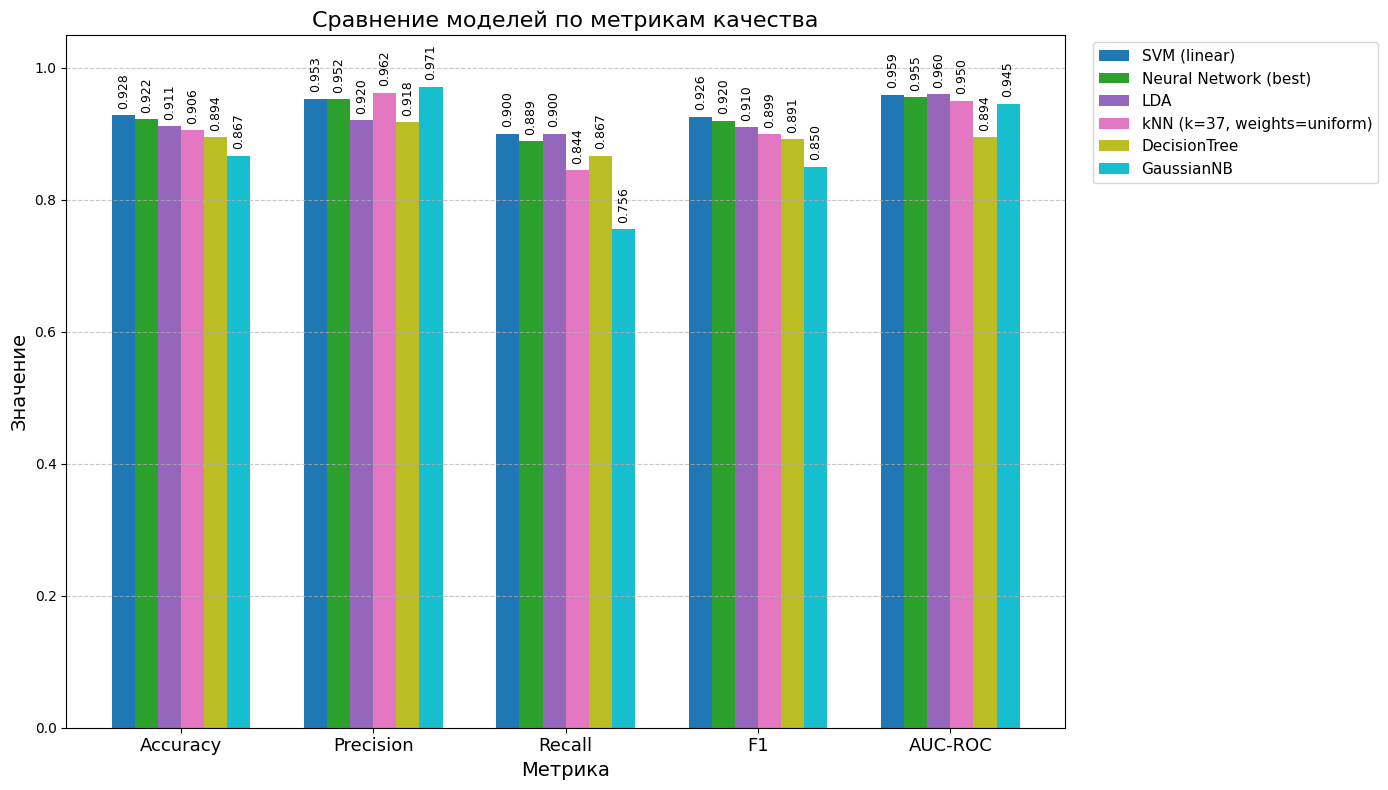

In [27]:
df_results = pd.DataFrame(results)
df_results = df_results.drop_duplicates(subset='Model', keep='last')
df_results = df_results.sort_values('F1', ascending=False).reset_index(drop=True)

print("Сравнительная таблица моделей (отсортировано по F1):")

formatted_df = df_results.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']:
    if col in formatted_df.columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.3f}')

display(formatted_df)

df_plot = df_results.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']]

models = df_plot.index.tolist()
metrics = df_plot.columns.tolist()
n_models = len(models)
n_metrics = len(metrics)

bar_width = 0.12
index = np.arange(n_metrics)
colors = plt.cm.tab10(np.linspace(0, 1, n_models))

plt.figure(figsize=(14, 8))
for i, model in enumerate(models):
    plt.bar(index + i * bar_width, df_plot.loc[model].values, 
            bar_width, label=model, color=colors[i])

plt.xlabel('Метрика', fontsize=14)
plt.ylabel('Значение', fontsize=14)
plt.title('Сравнение моделей по метрикам качества', fontsize=16)
plt.xticks(index + bar_width * (n_models - 1) / 2, metrics, fontsize=13)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        value = df_plot.loc[model, metric]
        plt.text(j + i * bar_width, value + 0.01, f'{value:.3f}', 
                 ha='center', va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

**Вывод:**

Абсолютный лидер — SVM (Linear). Модель метода опорных векторов с линейным ядром (синий столбец) показала наилучшие результаты практически по всем интегральным метрикам: Accuracy (0.928), F1-score (0.926) и AUC-ROC (0.959). Тот факт, что именно линейное ядро победило, является ключевым доказательством того, что классы изюма (Kecimen и Besni) линейно разделимы в пространстве признаков.

Группа лидеров (SVM, Neural Network, LDA). Нейросеть (зеленый) и Линейный дискриминантный анализ (фиолетовый) показывают результаты с разницей в доли процента (F1 0.920 и 0.910 соответственно). Это подтверждает, что для данной задачи подходят любые алгоритмы, умеющие строить линейные или плавные разделяющие поверхности. Нейросеть смогла приблизиться к SVM только благодаря тщательной настройке регуляризации (Dropout), в то время как SVM и LDA дали этот результат «из коробки» или с минимальной настройкой.

Специфика GaussianNB (Дисбаланс Precision/Recall). Посмотрим на голубые столбцы (GaussianNB). У этой модели самая высокая точность (Precision = 0.971), но самая низкая полнота (Recall = 0.756). Он боится ошибиться, поэтому предсказывает класс "1" (Besni) только тогда, когда уверен на 100%. Из-за этого он почти не допускает ложных срабатываний (высокий Precision), но пропускает четверть реальных объектов целевого класса (низкий Recall). Из-за этого перекоса его F1-score самый низкий (0.850).

kNN и Decision Tree (Середние). Метод ближайших соседей (розовый) и Дерево решений (желтый) показали достойные, но не выдающиеся результаты (F1 ≈ 0.89-0.90). kNN также страдает от дисбаланса (высокий Precision, но проседающий Recall), хотя и не так сильно, как Байес.

Для задачи классификации сортов изюма наилучшей моделью является SVM с линейным ядром. F1-score = 0.926. Модель требует настройки всего одного параметра (C) и не склонна к переобучению так сильно, как нейросети или деревья. Она идеально балансирует между тем, чтобы находить все объекты класса (Recall) и не брать лишнее (Precision), о чем говорят почти равные значения этих метрик (0.900 и 0.953).

## 7. Заключение

В рамках данной лабораторной работы была успешно выполнена задача бинарной классификации сортов изюма Kecimen и Besni на основе анализа их физических параметров. Исследование проводилось на базе набора данных Raisin Dataset с применением шести различных алгоритмов машинного обучения: от классических линейных моделей до полносвязной нейронной сети. Критически важным этапом работы стала предварительная обработка данных, в частности масштабирование признаков, что обеспечило корректную работу метрических алгоритмов и быструю сходимость градиентных методов.

По результатам сравнительного анализа абсолютным лидером стал Метод опорных векторов (SVM) с линейным ядром, показавший наивысшие значения интегральных метрик F1-score и AUC-ROC. Успех линейного SVM, а также высокие результаты Линейного дискриминантного анализа (LDA), позволяют сделать фундаментальный вывод о структуре исследуемых данных: классы сортов изюма являются линейно разделимыми в пространстве признаков. Это означает, что геометрические характеристики объектов имеют достаточно четкую границу различия, и применение сложных нелинейных ядер (RBF, Polynomial) в данном случае является избыточным и не приводит к приросту качества.

Нейронная сеть (многослойный перцептрон) также продемонстрировала высокую эффективность, заняв второе место и уступив лидеру лишь доли процента. Однако, в отличие от классических методов, достижение такого результата потребовало значительных усилий по настройке гиперпараметров. Учитывая небольшой объем датасета (всего 900 записей), эксперимент показал высокую склонность сложных моделей к переобучению. Эту проблему удалось решить только путем применения сильной регуляризации (Dropout 0.5) и аккуратного подбора скорости обучения. Характерное поведение кривых обучения, где метрики на валидации превышали метрики на тренировке, подтвердило эффективность выбранной стратегии регуляризации.

Среди остальных алгоритмов стоит отметить специфику работы Наивного байесовского классификатора (GaussianNB). Несмотря на самый низкий итоговый результат по F1-score, эта модель продемонстрировала максимальную точность (Precision), что говорит о её «консервативности»: алгоритм практически не допускает ложных срабатываний, но склонен пропускать значительную часть объектов целевого класса. Деревья решений и метод ближайших соседей (kNN) показали стабильные средние результаты, однако не смогли превзойти линейные методы в обобщающей способности.

Таким образом, итоговой рекомендацией для практического применения в задаче сортировки изюма является использование Метода опорных векторов с линейным ядром. Данный алгоритм обеспечивает наилучший баланс между точностью и полнотой, обладает высокой вычислительной эффективностью и устойчивостью, превосходя как более простые, так и более сложные альтернативы на данном наборе данных.